Updated: 26/01/2024

This workbook investigates whether the mapping of (2,2,0,1)x(2,2,0,1) is genuinely mapping a quadratic mode or if it's overfitting. The code uses the updated CCE file. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import qnmfitsrd as qnmfits
from multiprocessing import Pool
from spatial_reconstruction_tests.spatial_reconstruction import *
from matplotlib.animation import FuncAnimation
from scipy.interpolate import UnivariateSpline
from Visualisation.qnm_vis import * 
import datetime

l_max = 5
n_max = 5

t0 = 0 # This is based on the mismatch generated by the animation 

qnm_vis = qnm_vis() 

In [3]:
#sim = qnmfits.SXS(ID=305, zero_time=(2,2))
sim = qnmfits.CCE_to_sim_simplified(sim_num='0305')

AttributeError: module 'qnmfitsrd' has no attribute 'CCE_to_sim_simplified'

In [ ]:
mapping = [(2,2,0,1,2,2,0,1)]

QNMs = [(lam,mu,n,p) for lam in np.arange(2, l_max+1)
                        for mu in np.arange(-lam, lam+1)
                           for n in np.arange(0, n_max+1)
                              for p in (-1, +1)]

best_fit = qnmfits.mapping_multimode_ringdown_fit(sim.times, 
                                        sim.h, 
                                        modes=QNMs,
                                        Mf=sim.Mf,
                                        chif=sim.chif_mag,
                                        t0=t0,
                                        mapping_modes=mapping,
                                        spherical_modes=[(l,m) for l in np.arange(2, l_max+1)
                                                               for m in np.arange(-l,l+1)])

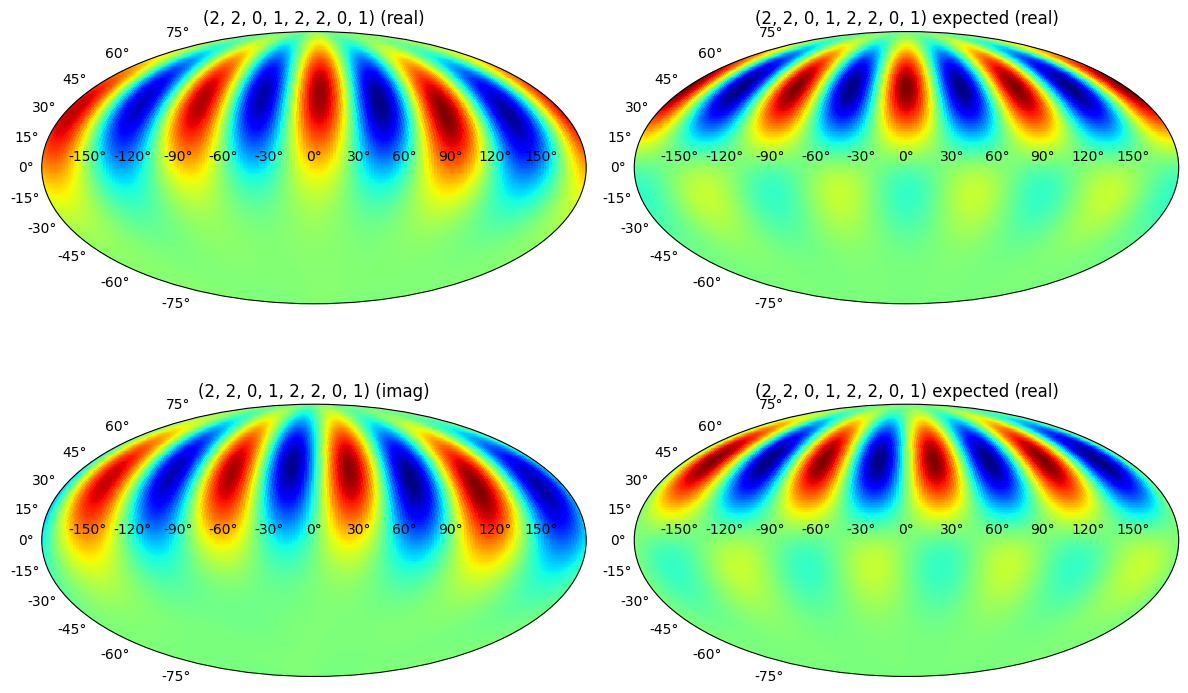

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, 
                        subplot_kw={'projection': 'mollweide'}, 
                        figsize=(12,8))

lon = np.linspace(-np.pi, np.pi, 200)
lat = np.linspace(-np.pi/2, np.pi/2, 200)

map = (2,2,0,1,2,2,0,1)

Lon, Lat = np.meshgrid(lon, lat)
F = mode_mapping(np.pi/2-Lat, Lon, best_fit, map, l_max)
G = spheroidal(np.pi/2-Lat, Lon, map, l_max, sim.chif_mag)

axs[0,0].title.set_text(str(map)+' (real)')
axs[0,0].pcolormesh(Lon, Lat, np.real(F), cmap=plt.cm.jet)

axs[1,0].title.set_text(str(map)+' (imag)')
axs[1,0].pcolormesh(Lon, Lat, np.imag(F), cmap=plt.cm.jet)

axs[0,1].title.set_text(str(map)+' expected (real)')
axs[0,1].pcolormesh(Lon, Lat, np.real(G), cmap=plt.cm.jet)

axs[1,1].title.set_text(str(map)+' expected (real)')
axs[1,1].pcolormesh(Lon, Lat, np.imag(G), cmap=plt.cm.jet)

plt.tight_layout()
plt.show()

### Are we overfitting the (4,4) mode?

If we are overfitting, the (4,4) mode will always be given a large amplitude, with other mode contributions being noise. We can test whether this is true by:

1. Animating the quadratic plot and looking at the time dependence
2. Removing the (4,4) mode and checking how the subdominant modes behave over time
3. Plotting the power spectrum (and possibly checking how this behaves over time)

#### 1. Animate the quadratic plot

201it [58:14, 17.39s/it]                         


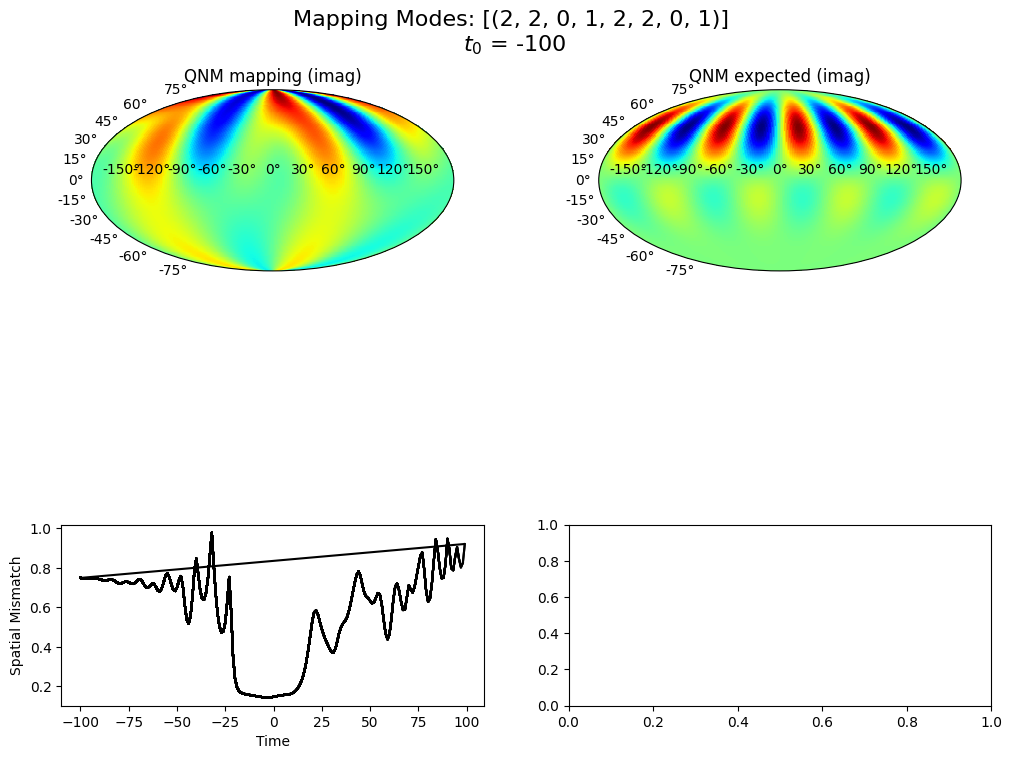

In [ ]:
id = datetime.datetime.now()

t_start = -100
t_end = 100
t_step = 1

ani = qnm_vis.animate_mapping(sim, tstart=t_start, tstop=t_end, tstep = t_step, 
                               mapping_QNMs=QNMs, mapping=mapping, l_max=l_max,
                               mapping_spherical_modes=None, 
                               projection='mollweide')

ani.save(f'mapping_{id}.mp4', writer='ffmpeg')

The quadratic mode appears to be successfully mapped for a small interval approx -10 to 10. 

#### 2. Remove the (4,4) mode and plot

In [ ]:
mapping = [(2,2,0,1,2,2,0,1)]

QNMs = [(lam,mu,n,p) for lam in np.arange(2, l_max+1)
                        for mu in np.arange(-lam, lam+1)
                           for n in np.arange(0, n_max+1)
                              for p in (-1, +1)]

best_fit = qnmfits.mapping_multimode_ringdown_fit(sim.times, 
                                        sim.h, 
                                        modes=QNMs,
                                        Mf=sim.Mf,
                                        chif=sim.chif_mag,
                                        t0=t0,
                                        mapping_modes=mapping,
                                        spherical_modes=[(l,m) for l in np.arange(2, l_max+1)
                                                               for m in np.arange(-l,l+1)])

In [ ]:
removed_spherical = (4,4)

def mode_mapping_new(theta, phi, best_fit, mapping, l_max):
    wigner = spherical.Wigner(l_max)
    R = quaternionic.array.from_spherical_coordinates(theta, phi)
    Y = wigner.sYlm(-2, R)

    ans = np.zeros_like(theta, dtype=complex)
    i = 0
    for loop in range(len(best_fit['C'])):
        if best_fit['modes'][loop]==mapping:
            if best_fit['spherical_modes'][i] == removed_spherical:
                i += 1
                continue
            A = best_fit['C'][loop]
            ans += A * Y[:,:,wigner.Yindex(*best_fit['spherical_modes'][i])]
            i += 1
    ans /= np.max(np.abs(ans)) # normalise peak value
    return ans

def spheroidal_new(theta, phi, mapping, l_max, chif):
    wigner = spherical.Wigner(l_max)
    R = quaternionic.array.from_spherical_coordinates(theta, phi)
    Y = wigner.sYlm(-2, R)

    ans = np.zeros_like(theta, dtype=complex)
    if len(mapping)==4:
        l, m, n, p = mapping
        for lp in np.arange(2, l_max+1):
            if lp == removed_spherical[0] and m == removed_spherical[1]:
                continue
            ans += qnmfits.qnm.mu(lp, m, l, m, n, p, chif) * Y[:,:,wigner.Yindex(lp, m)]
    elif len(mapping)==8:
        a, b, c, sign1, e, f, g, sign2 = mapping
        j = b + f
        for i in np.arange(2, l_max+1):
            if i == removed_spherical[0] and j == removed_spherical[1]:
                continue
            ans += qnmfits.qnm.alpha([(i,j)+mapping], chif) * Y[:,:,wigner.Yindex(i,j)]

    ans /= np.max(np.abs(ans)) # normalise peak value
    return ans

0.4999960286289703


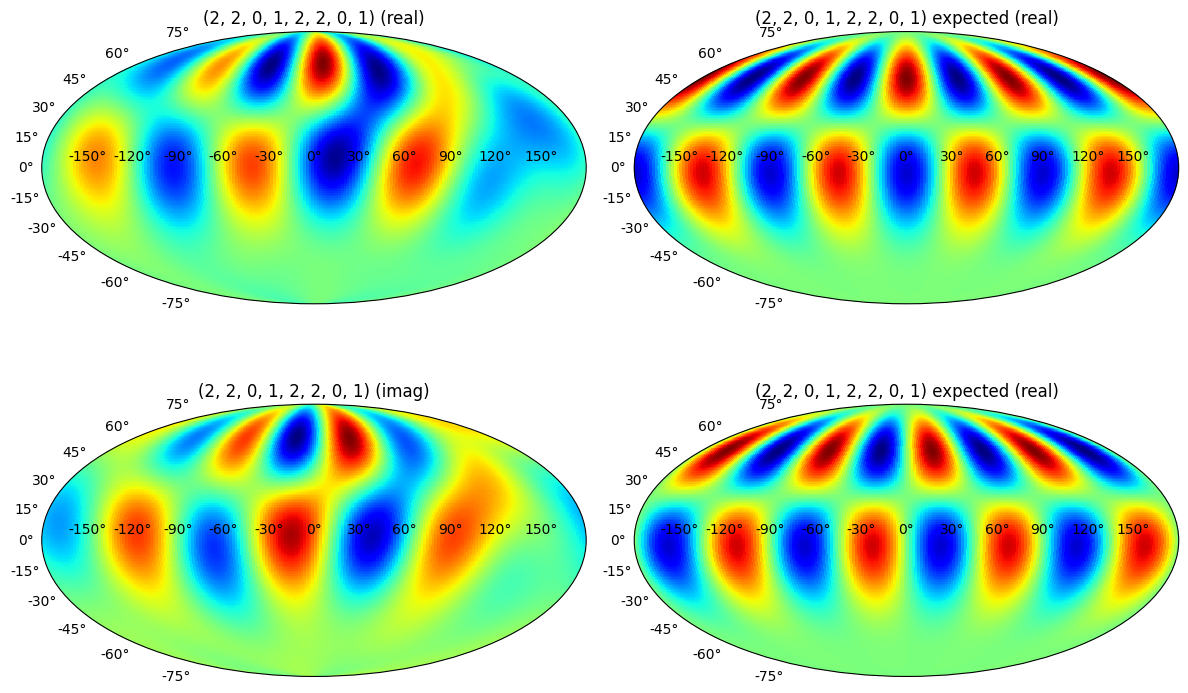

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, 
                        subplot_kw={'projection': 'mollweide'}, 
                        figsize=(12,8))

lon = np.linspace(-np.pi, np.pi, 200)
lat = np.linspace(-np.pi/2, np.pi/2, 200)

map = mapping[0]

Lon, Lat = np.meshgrid(lon, lat)

F = mode_mapping_new(np.pi/2-Lat, Lon, best_fit, map, l_max)
G = spheroidal_new(np.pi/2-Lat, Lon, map, l_max, sim.chif_mag)

sm, _, _ = spatial_mismatch(F, G)
print(sm)

axs[0,0].title.set_text(str(map)+' (real)')
axs[0,0].pcolormesh(Lon, Lat, np.real(F), cmap=plt.cm.jet)

axs[1,0].title.set_text(str(map)+' (imag)')
axs[1,0].pcolormesh(Lon, Lat, np.imag(F), cmap=plt.cm.jet)

axs[0,1].title.set_text(str(map)+' expected (real)')
axs[0,1].pcolormesh(Lon, Lat, np.real(G), cmap=plt.cm.jet)

axs[1,1].title.set_text(str(map)+' expected (real)')
axs[1,1].pcolormesh(Lon, Lat, np.imag(G), cmap=plt.cm.jet)

plt.tight_layout()
plt.show()

The remaining modes partially agree with the expected pattern. 

#### 3. Plot the 'power spectrum'

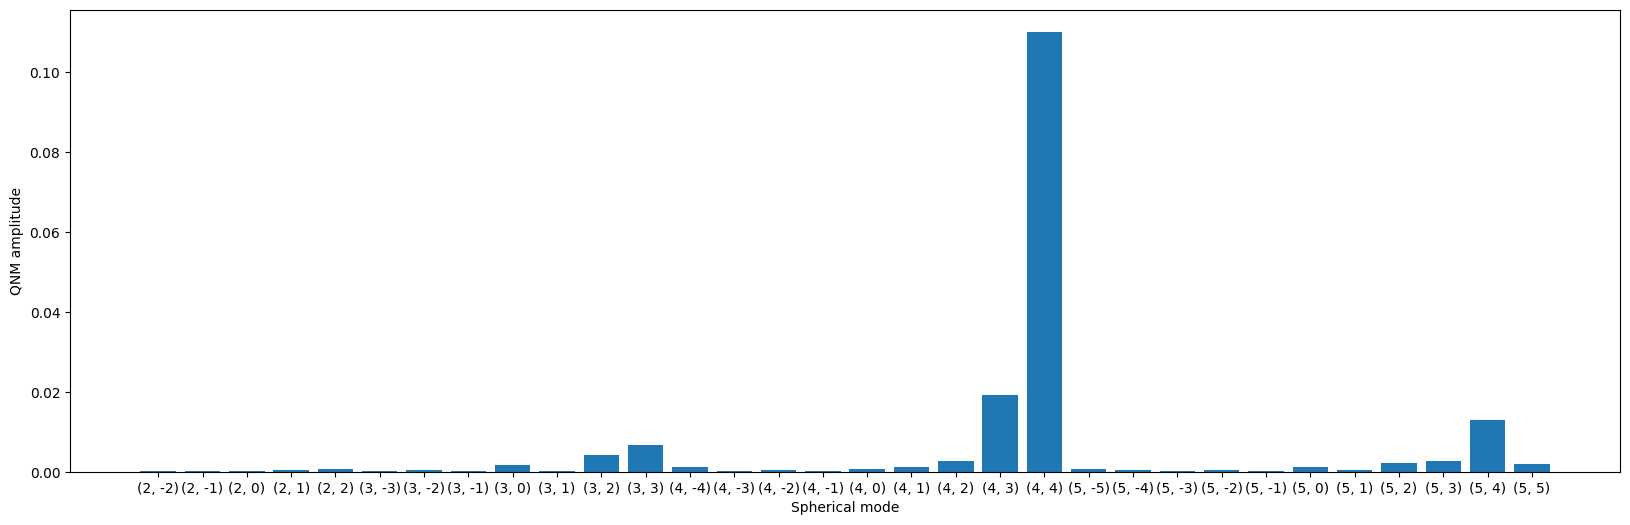

In [ ]:
map = mapping[0]

mode = []
amplitude = []

i = 0 

for loop in range(len(best_fit['C'])):
    if best_fit['modes'][loop] == map:
        A = best_fit['C'][loop]
        spherical_mode = best_fit['spherical_modes'][i]
        i += 1
        mode.append(str(spherical_mode)) 
        amplitude.append(abs(A))

fig, ax = plt.subplots(figsize=(20, 6))
plt.bar(mode, amplitude, colour = 'black')
plt.xlabel('Spherical mode')
plt.ylabel('QNM amplitude')
plt.show()
        


Animate this: 

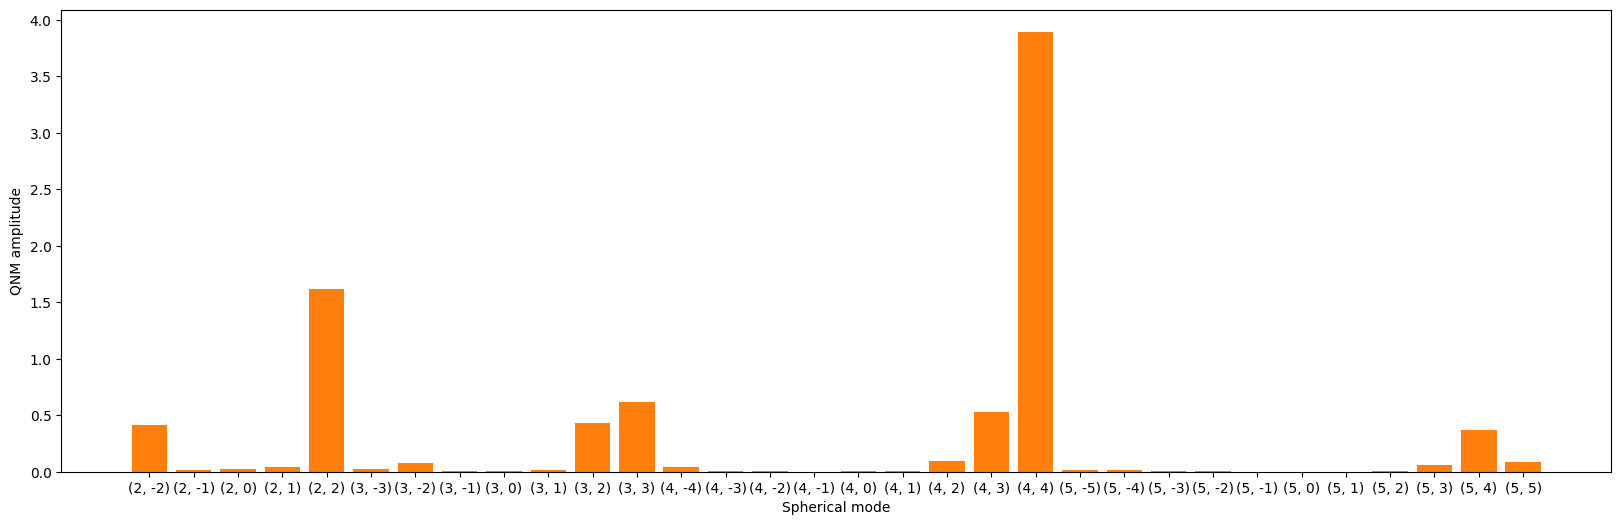

In [ ]:
fig, ax = plt.subplots(figsize=(20, 6))

def update(step):

    best_fit = qnmfits.mapping_multimode_ringdown_fit(sim.times, 
                                            sim.h, 
                                            modes=QNMs,
                                            Mf=sim.Mf,
                                            chif=sim.chif_mag,
                                            t0=step,
                                            mapping_modes=mapping,
                                            spherical_modes=[(l,m) for l in np.arange(2, l_max+1)
                                                                for m in np.arange(-l,l+1)])

    i = 0 

    for loop in range(len(best_fit['C'])):
        if best_fit['modes'][loop] == map:
            A = best_fit['C'][loop]
            spherical_mode = best_fit['spherical_modes'][i]
            i += 1
            mode.append(str(spherical_mode)) 
            amplitude.append(abs(A))

    plt.bar(mode, amplitude)
    plt.xlabel('Spherical mode')
    plt.ylabel('QNM amplitude')

id = datetime.datetime.now()
ani = FuncAnimation(fig, update, frames=range(-100, 100, 1), interval=100)
ani.save(f'spectral_variation_{id}.mp4', writer='ffmpeg')